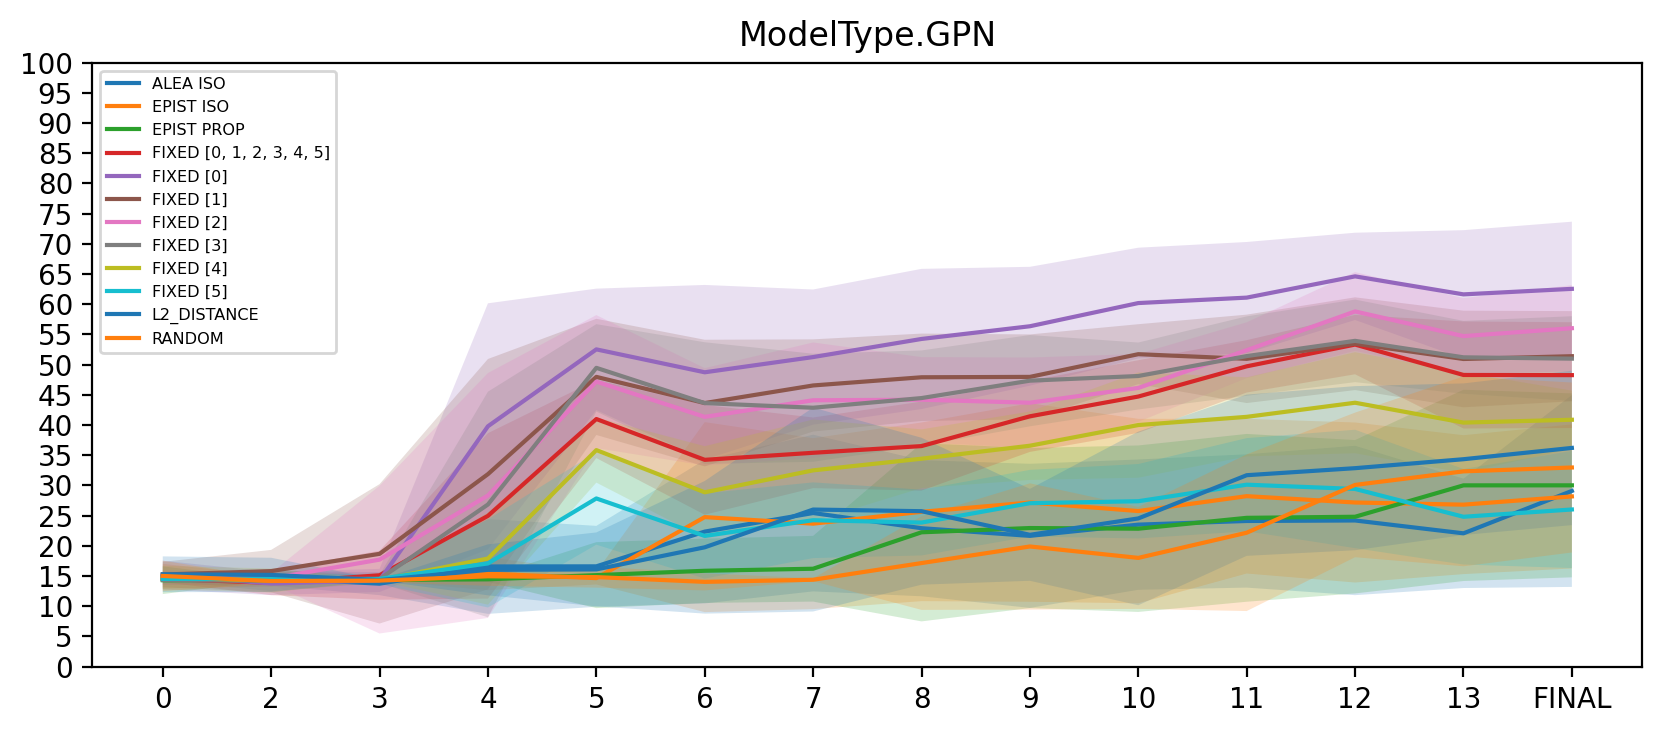

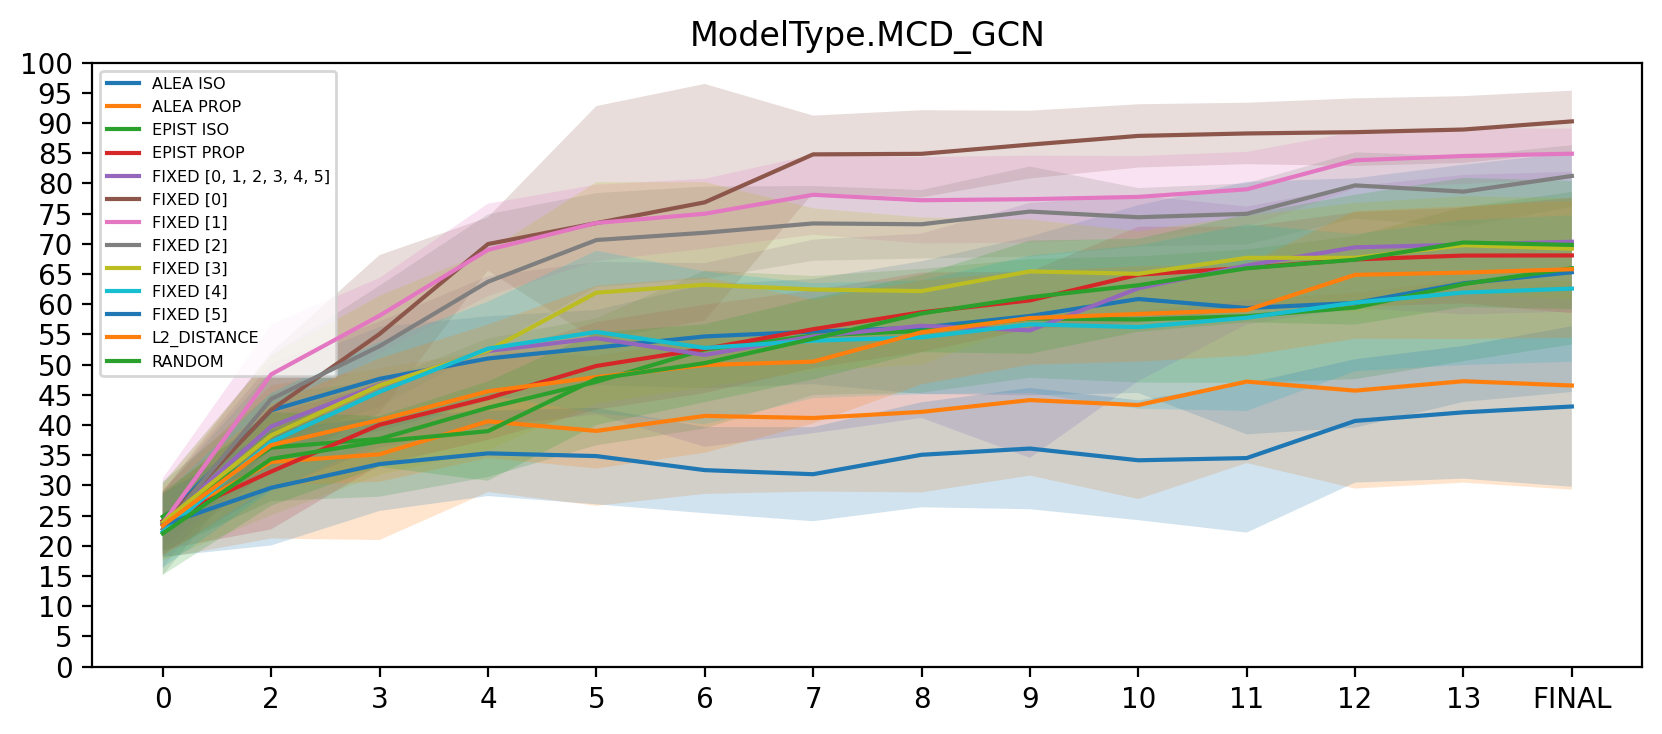

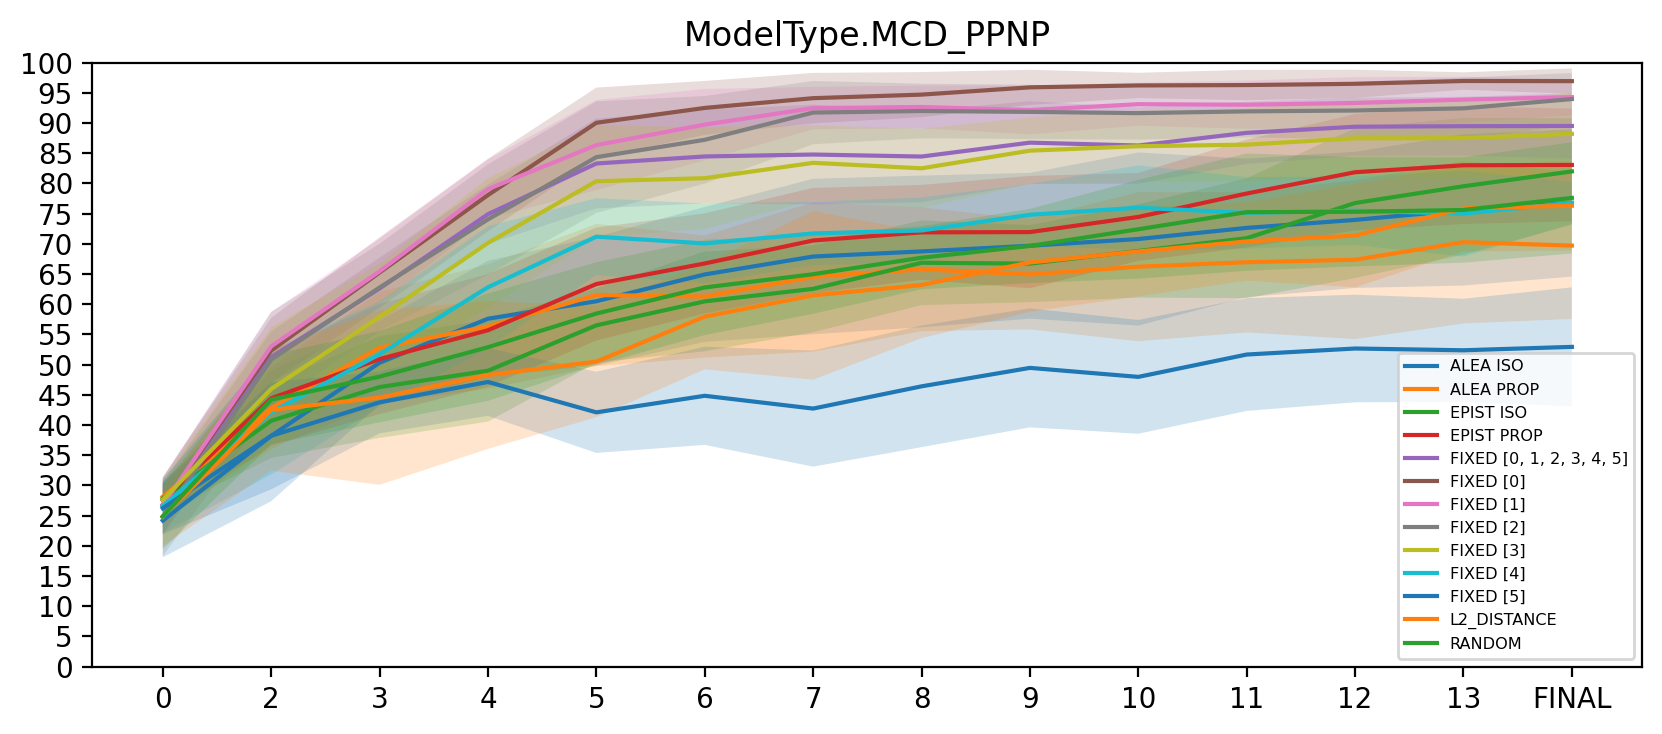

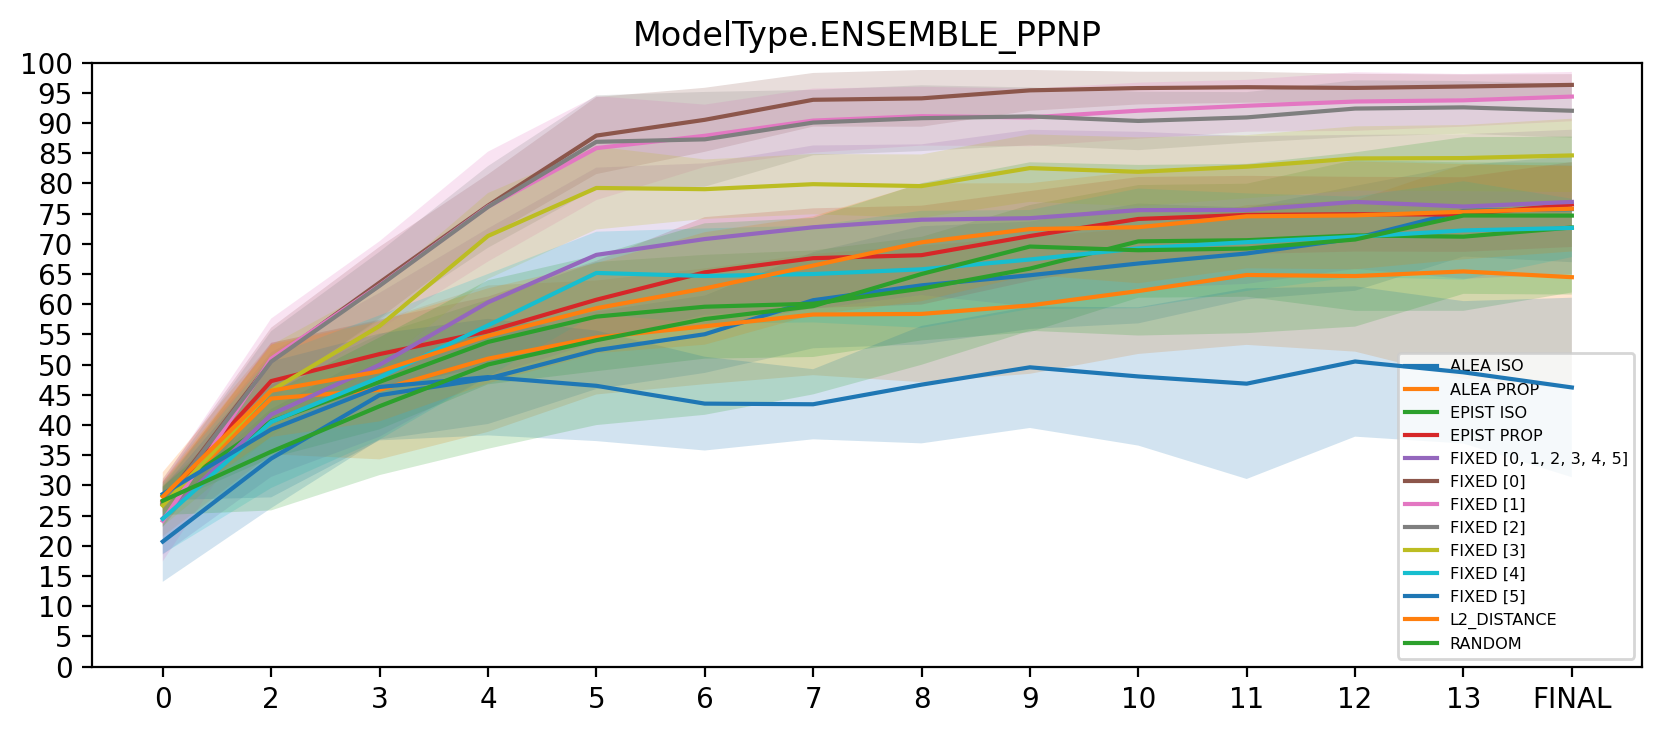

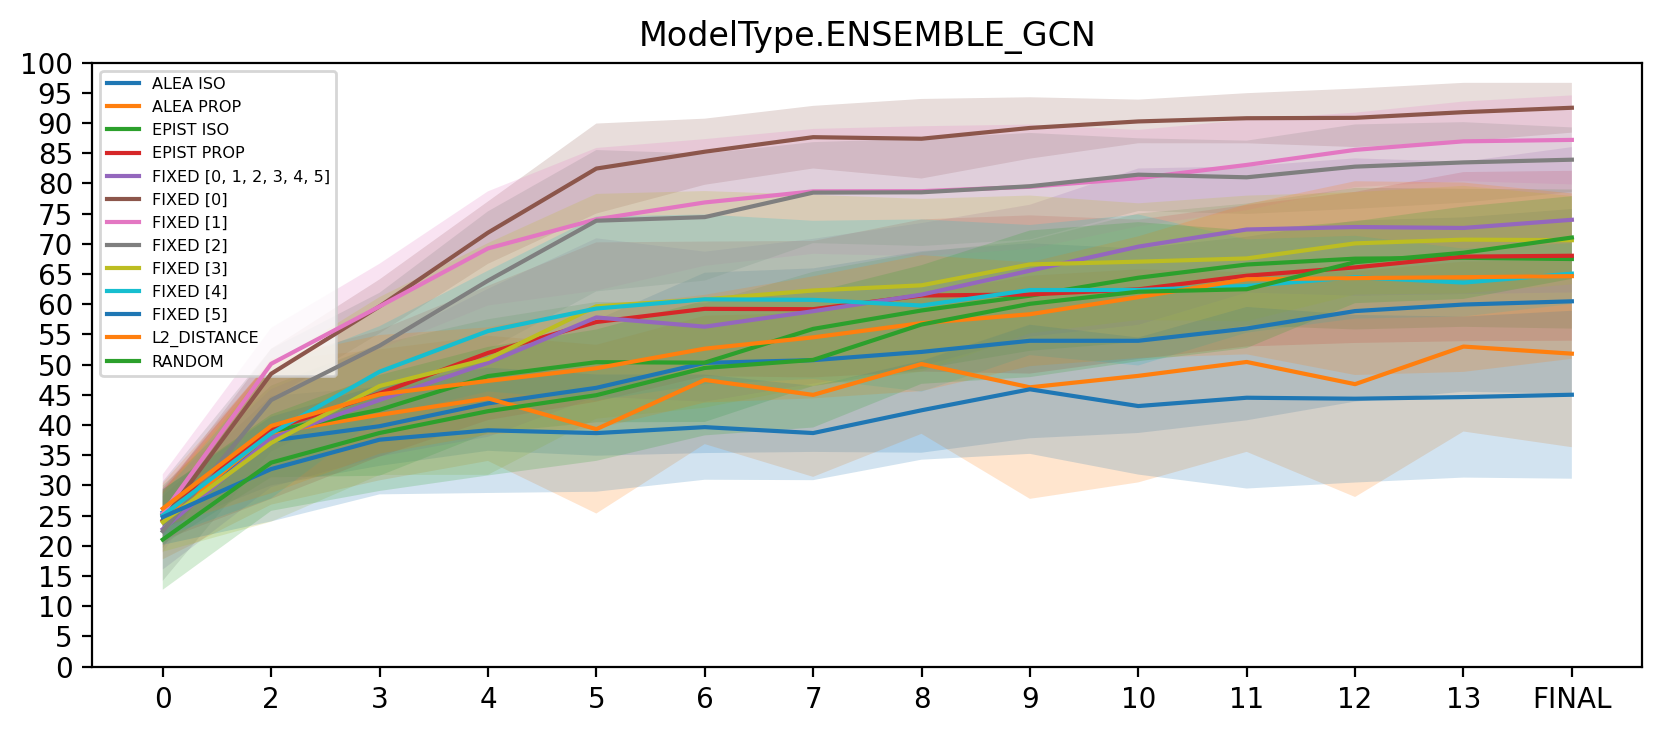

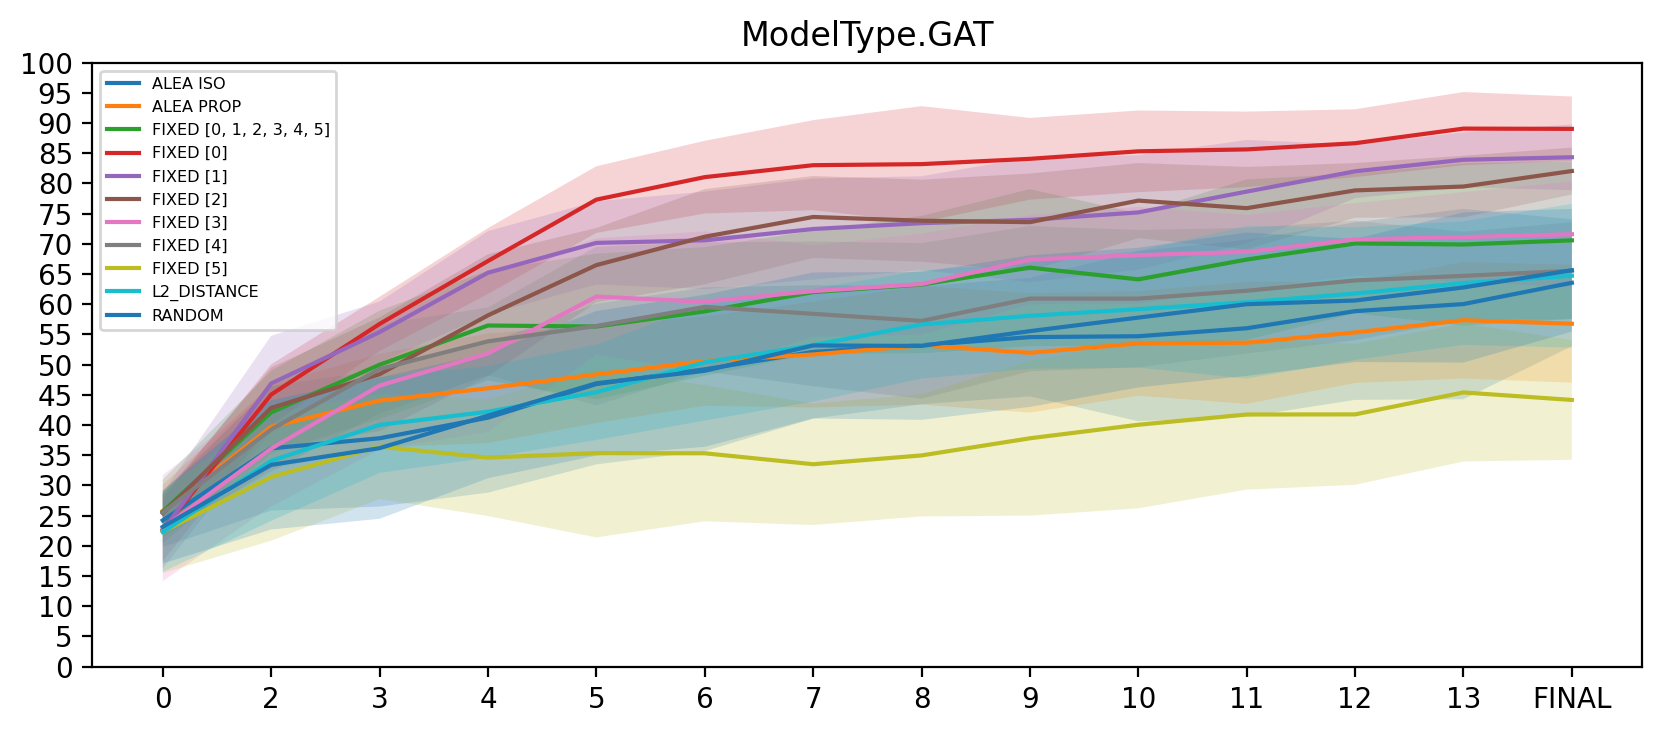

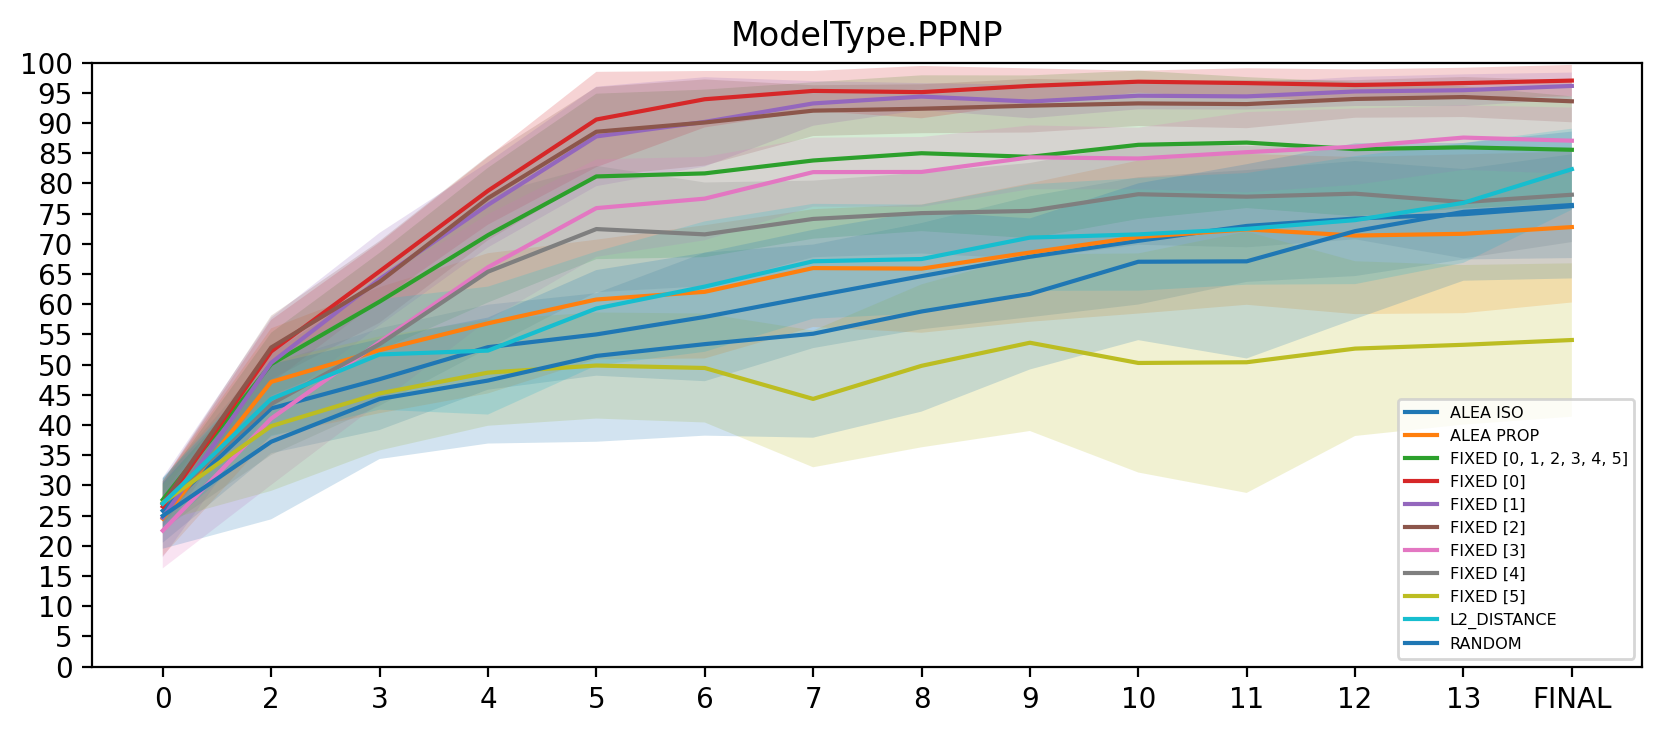

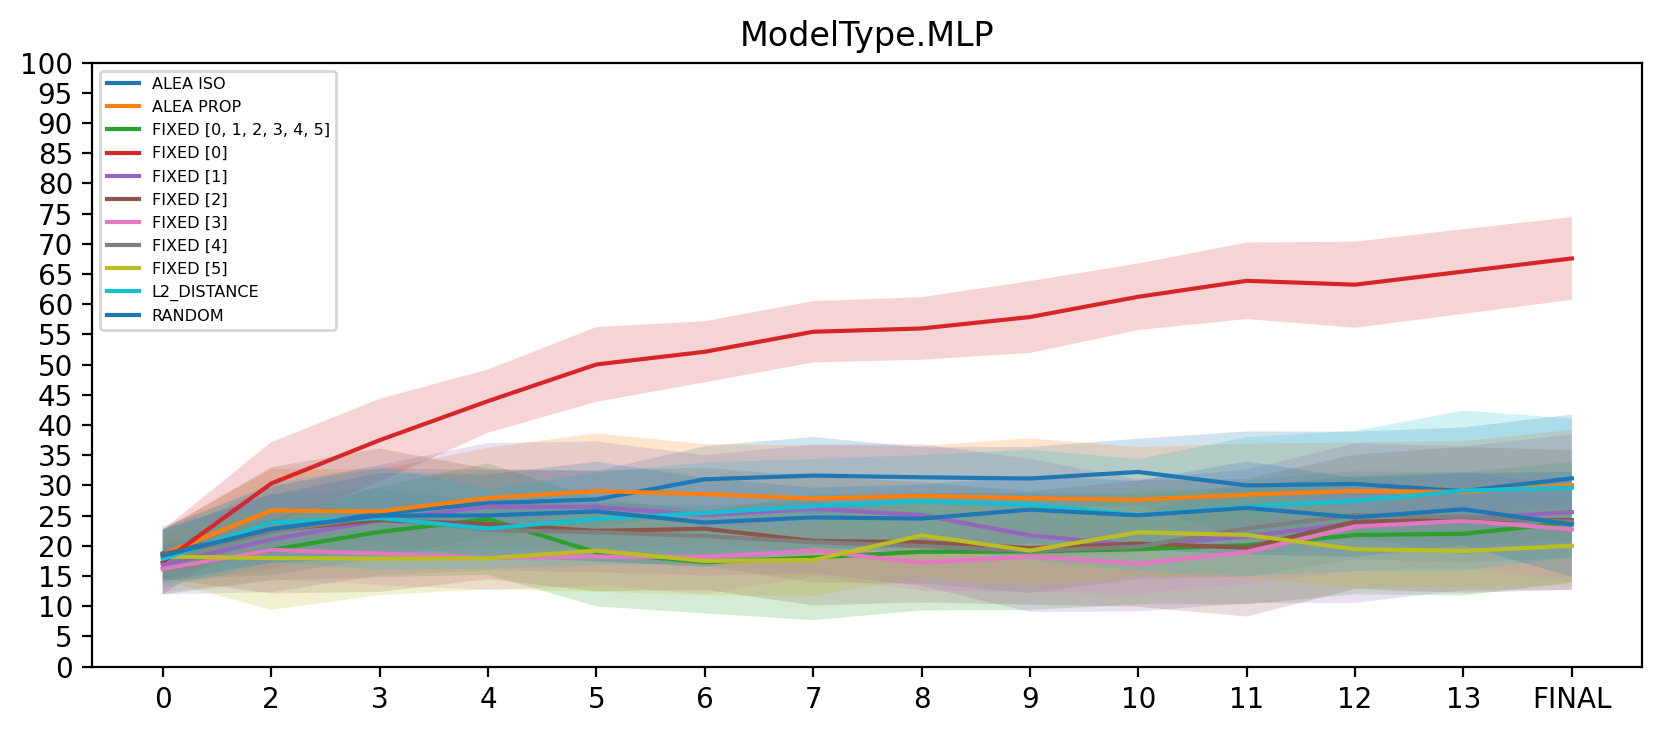

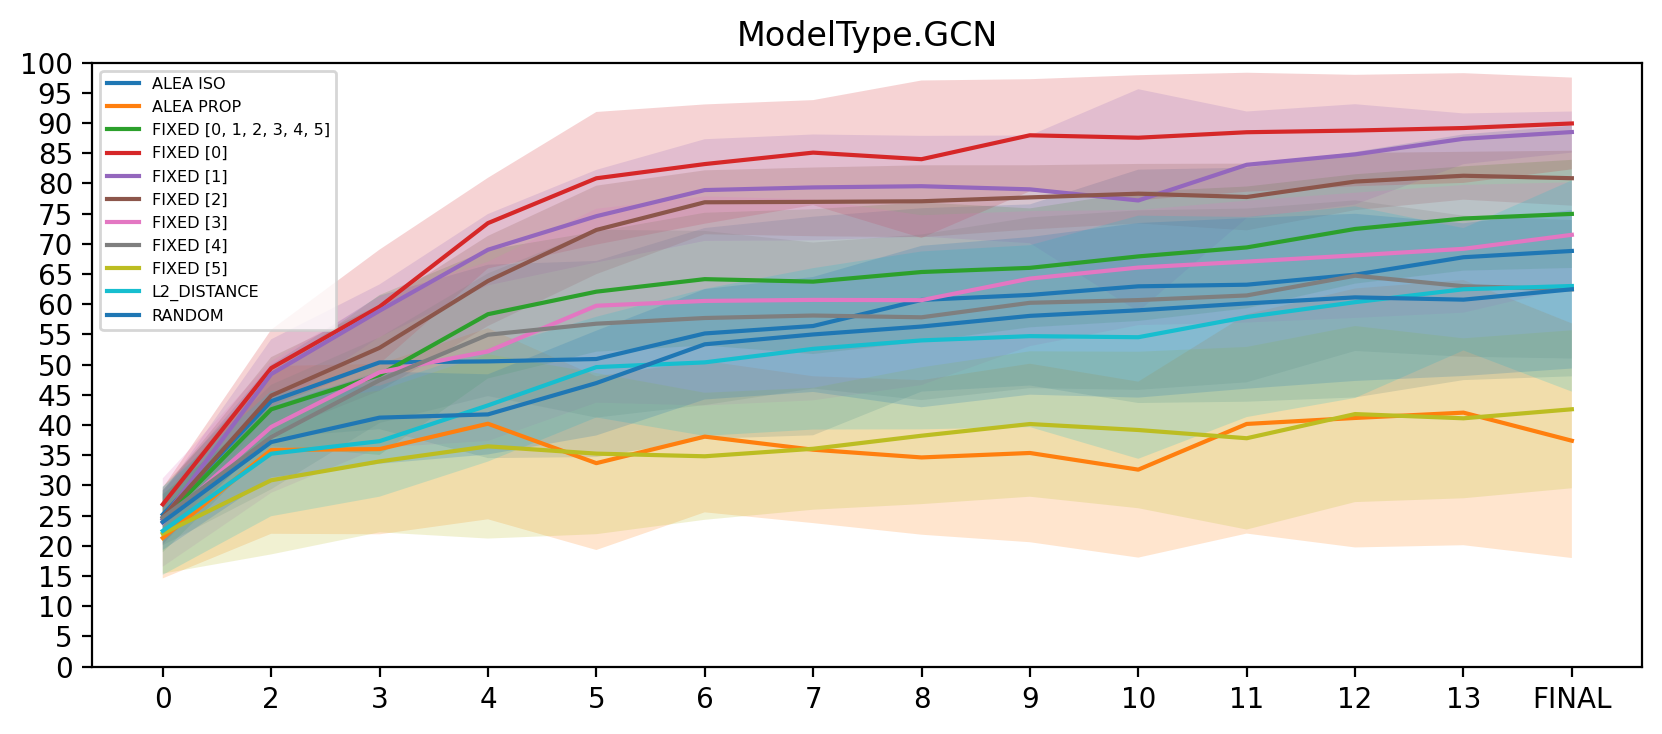

In [3]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import floor, ceil, sqrt

############### PARAMS ##################
tag = "sbmal_3_balanced_val[0]_v4"
show_selector = lambda x: True
#########################################

wandb.login()

"""
https://stackoverflow.com/questions/21654635/scatter-plots-in-pandas-pyplot-how-to-plot-by-category
"""

def afterPoint(str):
    return str.split('.')[-1]

def getKey(str):
    if str == 'FINAL':
        return 99999999
    elif str == 'BASELINE':
        return 1
    else:
        return int(str)
    
def getKeyName(name):
    names = {
        'ALEA ISO': 4, 
        'ALEA PROP': 3, 
        'EPIST ISO': 2, 
        'EPIST PROP': 1, 
        'L2_DISTANCE': 5, 
        'RANDOM': 6, 
        'FIXED [0, 1, 2, 3, 4, 5]': 7,
        'FIXED [0]': 12,
        'FIXED [1]': 11,
        'FIXED [2]': 10,
        'FIXED [3]': 9,
        'FIXED [4]': 8,
        'FIXED [5]': 7.5
    }
    return names[name]
        
    
def sortBy(datapoints):
    datapoints.sort(key=lambda datapoint: getKey(datapoint['timestep']) * 1000 + getKeyName(datapoint['selector']))
    
def getColumn(datapoints, column):
    return list(map(lambda x: x[column], datapoints))
    
    
def getSelectorName(run):
    active_learning_selector = afterPoint(run.config["experiment/active_learning_selector"])
    if active_learning_selector == "UNCERTAINTY":
        uncertainty_name = "ALEA" if afterPoint(run.config['experiment/active_learning_selector_uncertainty_mode']) == 'ALEATORIC' else 'EPIST'
        prop_name = 'ISO' if afterPoint(run.config['experiment/active_learning_selector_network_mode']) == 'ISOLATED' else 'PROP'
        active_learning_selector = f"{uncertainty_name} {prop_name}"
    elif active_learning_selector == "FIXED":
        prop_name = run.config['experiment/active_learning_training_type']
        active_learning_selector = f"{active_learning_selector} {prop_name}"
        
    return active_learning_selector

SUMMARY_FINAL_ACCURACY = '/eval/VALTEST/PROPAGATED/accuracy'
AL_PREFIX = 'mean/al/'
AL_SUFFIX = '/VALTEST/PROPAGATED/accuracy'

api = wandb.Api(timeout=100)
runs = api.runs("tum_daml_ba_antoniooroz/GR2", {"tags" : tag})

runs_per_model = {}

for run in runs:
    if run.config["debug"] or run.state != 'finished':
        continue
    
    model_type = str(run.config["model/type"])
    
    if model_type in runs_per_model:
        runs_per_model[model_type].append(run)
    else:
        runs_per_model[model_type] = [run]
        
for key, runs in runs_per_model.items():
    datapoints = []
    SAMPLES = (run.config['experiment/seeds/end'] - run.config['experiment/seeds/start']) * run.config['experiment/iterations_per_seed']
    
    for run in runs:
        model = afterPoint(run.config["model/type"])
        
        #if run.config['experiment/active_learning_l2_distance_use_centroids']==True and afterPoint(run.config['experiment/active_learning_selector'])=='L2_DISTANCE':
        #    continue
    
        active_learning_selector = getSelectorName(run)
        
        if not show_selector(active_learning_selector):
            continue

        for summary_key, summary_value in run.summary.items():
            if summary_key.startswith(AL_PREFIX) and summary_key.endswith(AL_SUFFIX):
                num = summary_key.replace(AL_PREFIX, '').replace(AL_SUFFIX, '')
                
                if num == '1':
                    continue
                
                datapoints.append({
                    'accuracy': summary_value*100,
                    'deviation': run.summary[summary_key.replace('mean/', 'std/', 1)]*100,
                    'error': run.summary[summary_key.replace('mean/', 'std/', 1)]*100/sqrt((SAMPLES)),
                    '95-confidence': run.summary[f"std{SUMMARY_FINAL_ACCURACY}"]*100/sqrt((SAMPLES))*1.95964,
                    'max': run.summary[summary_key.replace('mean/', 'max/', 1)]*100,
                    'min': run.summary[summary_key.replace('mean/', 'min/', 1)]*100,
                    'timestep': num,
                    'selector': active_learning_selector
                })
        datapoints.append({
            'accuracy': run.summary[f"mean{SUMMARY_FINAL_ACCURACY}"]*100,
            'deviation': run.summary[f"std{SUMMARY_FINAL_ACCURACY}"]*100,
            'error': run.summary[f"std{SUMMARY_FINAL_ACCURACY}"]*100/sqrt((SAMPLES)),
            '95-confidence': run.summary[f"std{SUMMARY_FINAL_ACCURACY}"]*100/sqrt((SAMPLES))*1.95964,
            'max': run.summary[f"max{SUMMARY_FINAL_ACCURACY}"]*100,
            'min': run.summary[f"min{SUMMARY_FINAL_ACCURACY}"]*100,
            'timestep': 'FINAL',
            'selector': active_learning_selector
        })
        
    sortBy(datapoints)
        
    df = pd.DataFrame(dict(
        x=getColumn(datapoints, 'timestep'), 
        y=getColumn(datapoints, 'accuracy'), 
        err=getColumn(datapoints, 'deviation'), 
        label=getColumn(datapoints, 'selector'), 
        minimum=getColumn(datapoints, 'min'),
        maximum=getColumn(datapoints, 'max')))
    groups = df.groupby('label')
    
    fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
    ax.margins(0.05)
    for name, group in groups:
        ax.set_ylim([0.0, 100])
        ax.plot(group.x, group.y, '-', label=name, zorder=10)
        ax.fill_between(group.x, group.y-group.err, group.y+group.err, label=f"_{name}", alpha=0.2, zorder=0)
        #ax.fill_between(group.x, group.minimum, group.maximum, label=f"_{name}", alpha=0.2, zorder=0)
        ax.yaxis.set_ticks(np.arange(0, 105, 5))
    
    ax.legend(fontsize = 'xx-small')
    plt.title(key)
    plt.show()
